---

# Comparative Behaviour of One-Class Anomaly Detectors on Controlled Network Flow Data (recruiter version)

---


This showcase notebook presents a compact, recruiter-friendly version of a larger exploratory analysis.


It compares two one-class anomaly detection methods on controlled network flow data:


- **Isolation Forest**

- **One-Class SVM**


The goal is not to optimise accuracy on a toy dataset, but to illustrate **operationally relevant behaviour**:
how model performance changes as we vary the **decision threshold** (target false-positive rate) and how this relates to the **geometry of anomaly scores**.


## 1. Setup
This notebook assumes it is run from the repository root and expects these CSVs:

- `data/demo/features/normal_flows.csv`
- `data/demo/features/scan_flows.csv`

The code below is intentionally lightweight and self-contained.

## 2. Load data

In [25]:
# --- Importing data
from pathlib import Path
import pandas as pd

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "data").exists() is False:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "features"

normal_flows = pd.read_csv(DATA_DIR / "normal_flows.csv")
scan_flows = pd.read_csv(DATA_DIR / "scan_flows.csv")


## 3. Threshold calibration experiment (fixed training size)
We fix the normal training size at **4096 flows** and calibrate thresholds on a **fixed normal holdout set**.

For a target false-positive rate (FPR) $\alpha$, we set the threshold to the $\alpha$-quantile of the holdout normal score distribution.
An observation is flagged as anomalous when its score falls **below** this threshold.

In [26]:
# --- Importing the models:
import sys
from pathlib import Path

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT / "src"))

import train_iforest, train_ocsvm

In [27]:
# --- Importing functions and datasets:
import math
import time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# deconstructed, slimlined train and test functions based on the train_* pipelines
import speedtest_src as st  # in local src directory

speedtest_train = "/tests/speedtest/data/features/normal_flows.csv"
speedtest_eval  = "/tests/speedtest/data/features/scan_flows.csv"

## 4. Calibration behaviour: metrics vs target FPR
These plots make the operating points explicit by using **target FPR** on the x-axis.
This avoids ambiguity when a model exhibits cliff-edge behaviour.

In [ ]:
# --- Threshold calibration sweep
# - Fix training size to 2^12 (=4096) normal flows
# - Fix a normal holdout set (1000) for calibration + evaluation
# - Sweep target_fpr over: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
# - Evaluate on: (fixed holdout normals) + (all anomalies)
# - Return a tidy DataFrame with PPV/NPV/Recall/F1/FPR + timings

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "tests").exists() and (PROJECT_ROOT.parent / "tests").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

NORMAL_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "normal_flows.csv"
ANOM_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "scan_flows.csv"

# ---- controls ----
train_n = 2**12
holdout_n = 1000
target_fprs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
reps = 10  # repeat to smooth randomness; set 1 for fastest
rng = np.random.default_rng(42)

# ---- load once ----
df_norm_all = st.load_features(NORMAL_PATH)
df_anom_all = st.load_features(ANOM_PATH)
if df_norm_all.empty or df_anom_all.empty:
    raise ValueError("One of the datasets is empty; check CSV paths.")

# fixed split: holdout + training pool
df_norm_all = df_norm_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
if len(df_norm_all) <= holdout_n:
    raise ValueError("Not enough normal rows to allocate holdout.")

df_hold = df_norm_all.iloc[:holdout_n].copy()
df_pool = df_norm_all.iloc[holdout_n:].copy()

if len(df_pool) < train_n:
    raise ValueError(f"Training pool too small ({len(df_pool)}) for train_n={train_n}.")

X_hold = st.select_feature_matrix(df_hold)
X_anom = st.select_feature_matrix(df_anom_all)

def _median(vals):
    return float(np.median(np.asarray(vals, dtype=float)))

def _metrics_from_preds(y_true, y_pred):
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    ppv = tp / (tp + fp) if (tp + fp) else 0.0
    npv = tn / (tn + fn) if (tn + fn) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    f1  = (2 * ppv * rec) / (ppv + rec) if (ppv + rec) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    return {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "ppv": ppv, "npv": npv, "recall": rec, "f1": f1, "fpr": fpr}

def run_model_sweep(model_name: str):
    rows = []

    for tfpr in target_fprs:
        fit_times, infer_times = [], []
        ppvs, npvs, recalls, f1s, fprs = [], [], [], [], []

        for _ in range(reps):
            # sample fixed-size training set
            idx = rng.choice(len(df_pool), size=train_n, replace=False)
            X_train = st.select_feature_matrix(df_pool.iloc[idx])

            # fit
            t0 = time.perf_counter()
            if model_name == "iforest":
                model = st.fit_iforest(X_train, contamination=0.05)
            elif model_name == "ocsvm":
                model = st.fit_ocsvm(X_train, nu=0.05, gamma="scale")
            else:
                raise ValueError("Unknown model_name")
            t1 = time.perf_counter()
            fit_times.append(t1 - t0)

            # score + threshold + evaluate
            t2 = time.perf_counter()
            scores_norm = model.decision_function(X_hold)
            scores_anom = model.decision_function(X_anom)

            thresh = float(np.quantile(scores_norm, tfpr))  # calibrated threshold from holdout normals

            y_true = np.concatenate([
                np.zeros(len(scores_norm), dtype=int),
                np.ones(len(scores_anom), dtype=int)
            ])
            scores_eval = np.concatenate([scores_norm, scores_anom])
            y_pred = (scores_eval < thresh).astype(int)

            m = _metrics_from_preds(y_true, y_pred)

            t3 = time.perf_counter()
            infer_times.append(t3 - t2)

            ppvs.append(m["ppv"]); npvs.append(m["npv"])
            recalls.append(m["recall"]); f1s.append(m["f1"])
            fprs.append(m["fpr"])

        rows.append({
            "model": model_name,
            "positive_class": "anomaly",
            "train_n": int(train_n),
            "holdout_n": int(holdout_n),
            "target_fpr": float(tfpr),
            "ppv_median": _median(ppvs),
            "npv_median": _median(npvs),
            "recall_median": _median(recalls),
            "f1_median": _median(f1s),
            "fpr_median": _median(fprs),
        })

    return pd.DataFrame(rows)

df_if  = run_model_sweep("iforest")
df_svm = run_model_sweep("ocsvm")
df_thr = pd.concat([df_if, df_svm], ignore_index=True)


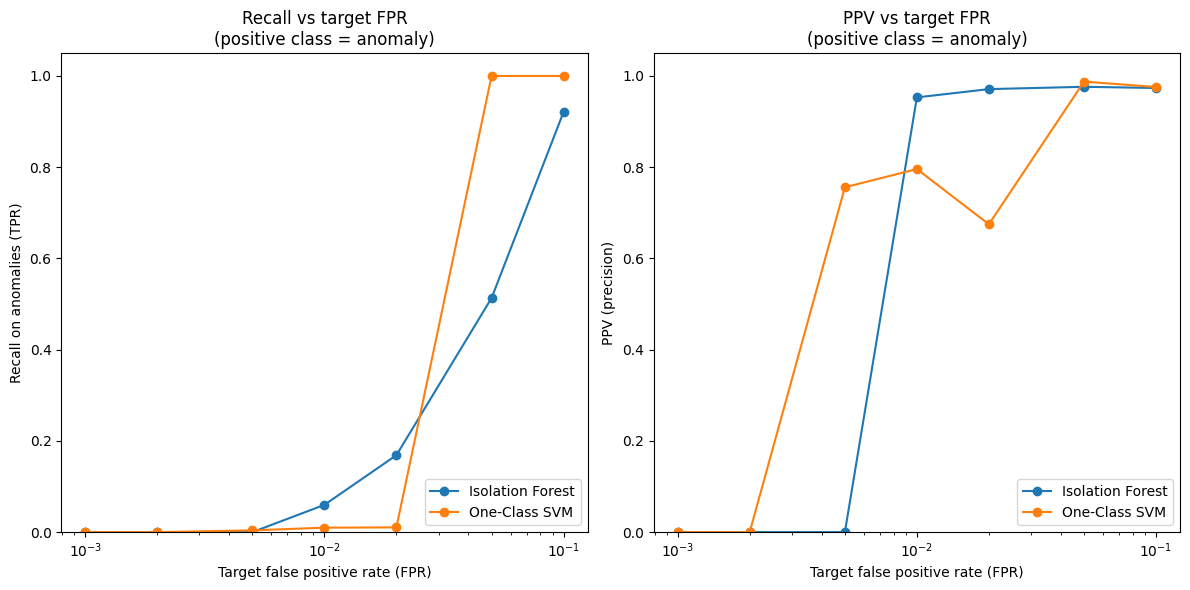

In [29]:
# --- Performance plots

label_map = {
    "iforest": "Isolation Forest",
    "ocsvm": "One-Class SVM"
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# ---- Left: Recall vs target FPR ----
ax = axes[0]
for name, sub in df_thr.groupby("model"):
    ax.plot(
        sub["target_fpr"],
        sub["recall_median"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log")
ax.set_xlabel("Target false positive rate (FPR)")
ax.set_ylabel("Recall on anomalies (TPR)")
ax.set_title("Recall vs target FPR\n(positive class = anomaly)")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")

# ---- Right: PPV vs target FPR ----
ax = axes[1]
for name, sub in df_thr.groupby("model"):
    ax.plot(
        sub["target_fpr"],
        sub["ppv_median"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log")
ax.set_xlabel("Target false positive rate (FPR)")
ax.set_ylabel("PPV (precision)")
ax.set_title("PPV vs target FPR\n(positive class = anomaly)")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


## 5. Score geometry: side-by-side KDEs
We visualise the **anomaly score distributions** (decision_function) for each model.
Histograms show empirical frequencies; KDEs provide a smoothed view of overlap and tails.

Threshold lines correspond to quantiles of the **normal holdout** score distribution at selected target FPRs.

In [30]:
# --- Decision function analysis

# ---- controls ----
train_n = 2**12
threshold_fprs = [0.01, 0.05, 0.10]
bins = 50

# assumes these already exist from earlier cells:
# df_pool, df_hold, df_anom_all
# st (speedtest_src)
# rng

# ---- prepare data ----
idx = rng.choice(len(df_pool), size=train_n, replace=False)
X_train = st.select_feature_matrix(df_pool.iloc[idx])
X_norm  = st.select_feature_matrix(df_hold)
X_anom  = st.select_feature_matrix(df_anom_all)

models = {
    "Isolation Forest": st.fit_iforest(X_train, contamination=0.05),
    "One-Class SVM":    st.fit_ocsvm(X_train, nu=0.05, gamma="scale"),
}

In [31]:
# --- Plot setup

# ---- controls ----
train_n = 2**12
threshold_fprs = [0.01, 0.05, 0.10]
bins = 80                 # more bins for a closer look
zoom = False              # set False to show full range
zoom_window = 0.25        # show scores in [-zoom_window, +zoom_window] around 0
use_logy = True          # set True to see tails

# ---- prepare data once ----
idx = rng.choice(len(df_pool), size=train_n, replace=False)
X_train = st.select_feature_matrix(df_pool.iloc[idx])
X_norm  = st.select_feature_matrix(df_hold)
X_anom  = st.select_feature_matrix(df_anom_all)

models = {
    "Isolation Forest": st.fit_iforest(X_train, contamination=0.05),
    "One-Class SVM":    st.fit_ocsvm(X_train, nu=0.05, gamma="scale"),
}

linestyle_map = {
    0.01: "--",   # dashed
    0.05: "-.",   # dash-dot
    0.10: ":"     # dotted
}


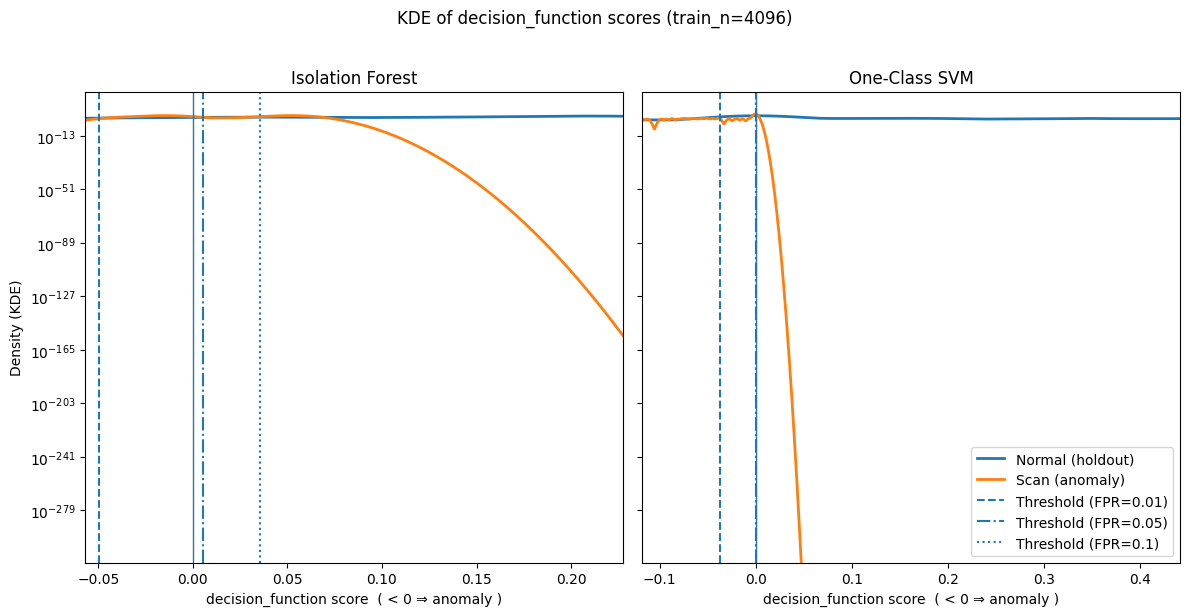

In [32]:
# --- Plotting KDEs

from scipy.stats import gaussian_kde

# --- KDE controls ---
kde_points = 800
kde_bw = "scott"   # or float multiplier, e.g. 0.8

linestyle_map = {
    0.01: "--",
    0.05: "-.",
    0.10: ":"
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    scores_norm = model.decision_function(X_norm)
    scores_anom = model.decision_function(X_anom)

    all_scores = np.concatenate([scores_norm, scores_anom])

    # x-range selection
    if zoom:
        lo, hi = -zoom_window, zoom_window
    else:
        lo = float(np.quantile(all_scores, 0.001))
        hi = float(np.quantile(all_scores, 0.999))
        if lo == hi:
            lo, hi = float(all_scores.min()), float(all_scores.max())

    x = np.linspace(lo, hi, kde_points)

    # KDE objects
    kde_norm = gaussian_kde(scores_norm)
    kde_anom = gaussian_kde(scores_anom)

    if isinstance(kde_bw, (int, float)):
        kde_norm.set_bandwidth(bw_method=kde_norm.factor * kde_bw)
        kde_anom.set_bandwidth(bw_method=kde_anom.factor * kde_bw)
    else:
        kde_norm.set_bandwidth(bw_method=kde_bw)
        kde_anom.set_bandwidth(bw_method=kde_bw)

    ax.plot(x, kde_norm(x), label="Normal (holdout)", linewidth=2)
    ax.plot(x, kde_anom(x), label="Scan (anomaly)", linewidth=2)

    # threshold lines
    for fpr in threshold_fprs:
        thresh = float(np.quantile(scores_norm, fpr))
        ax.axvline(
            thresh,
            linestyle=linestyle_map.get(fpr, "--"),
            linewidth=1.5,
            label=f"Threshold (FPR={fpr})"
        )

    # sklearn decision boundary
    ax.axvline(0.0, linestyle="-", linewidth=1)

    ax.set_title(f"{name}")
    ax.set_xlabel("decision_function score  ( < 0 ⇒ anomaly )")

    if use_logy:
        ax.set_yscale("log")

    ax.set_xlim(lo, hi)

axes[0].set_ylabel("Density (KDE)")
axes[1].legend(loc="best")

plt.suptitle(f"KDE of decision_function scores (train_n={train_n})", y=1.02)
plt.tight_layout()
plt.show()


## 6. Takeaway
- **Isolation Forest** behaves like a *soft anomaly scorer*: broad, overlapping scores produce a smooth, forgiving precision–recall trade-off as thresholds change.
- **One-Class SVM** behaves like a *hard boundary detector*: concentrated score geometry yields near-perfect performance when well-calibrated, but cliff-edge behaviour under small calibration shifts.

In practical settings where training representativeness and operating conditions may vary, Isolation Forest is often the safer baseline, while One-Class SVM can be strong when ample representative normal data and careful calibration are available.